# Custom populations

Custom populations can be created either by piecing together existing populations (spatial and luminosity populations) or building them from scratch with distributions.

**popsynth** comes loaded with many combinations of typical population distributions. However, we demonstrate here how to create your own.

## Creating distributions

The population samplers rely on distributions. Each population has an internal spatial and luminosity distribution. For example, lets look at a simple spatial distribution:


In [50]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1, grid=False)
green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"


import popsynth

import warnings
warnings.simplefilter('ignore')

In [37]:
from popsynth.distribution import SpatialDistribution


class SphericalDistribution(SpatialDistribution):
    def __init__(self, r_max=10, seed=1234, form=None, truth={}):

        
         # the latex formula for the ditribution
        form = r"4 \pi r2"
        
        # we do not need a "truth" dict here because
        # there are no parameters
        
        super(SphericalDistribution, self).__init__(
            r_max=r_max, seed=seed, name='sphere', form=form, truth={}
        )

    def differential_volume(self, r):

        # the differential volume of a sphere
        return 4 * np.pi * r * r

    def transform(self, L, r):

        # luminosity to flux
        return L / (4.0 * np.pi * r * r)
    
    def dNdV(self, r):
        
        # define some crazy change in the number/volume for fun
        
        return 10./(r+1)**2


We simply define the differential volume and how luminosity is transformed to flux in the metric. Here, we have a simple sphere out to some *r_max*. We can of course subclass this object and add a normalization.


Now we define a luminosity distribution.

In [38]:
from popsynth.distribution import LuminosityDistribution


class ParetoDistribution(LuminosityDistribution):
    def __init__(self, Lmin, alpha, seed=1234, name="pareto"):

        # the truth parameters for storage
        truth = dict(Lmin=Lmin, alpha=alpha)

        # the latex formula for the ditribution
        lf_form = r"\frac{\alpha L_{\rm min}^{\alpha}}{L^{\alpha+1}}"
        
        
        super(ParetoDistribution, self).__init__(
            seed=seed, name='pareto', form=lf_form, truth=truth
        )

        # since we have extra parameters, we need to tell the class about them
        self._construct_distribution_params(Lmin=Lmin, alpha=alpha)

    def phi(self, L):
        
        # the actual function, only for plotting 

        out = np.zeros_like(L)

        idx = L >= self.Lmin

        out[idx] = self.alpha * self.Lmin ** self.alpha / L[idx] ** (self.alpha + 1)

        return out

    def draw_luminosity(self, size=1):
        # how to sample the latent parameters
        return (np.random.pareto(self._params["alpha"], size) + 1) * self._params[
            "Lmin"
        ]

## Creating a population synthesizer

Now that we have defined our distributions, we can create a population synthesizer that encapsulated them

In [39]:
from popsynth.population_synth import PopulationSynth

class MyPopulation(PopulationSynth):
    def __init__(self, Lmin, alpha, r_max=5, seed=1234):
        
        # instantiate the distributions
        luminosity_distribution = ParetoDistribution(Lmin=Lmin, alpha=alpha, seed=seed)
        spatial_distribution = SphericalDistribution(r_max=r_max)

        # pass to the super class
        super(MyPopulation, self).__init__(         
            spatial_distribution=spatial_distribution,
            luminosity_distribution=luminosity_distribution,
            seed=seed
        )

In [44]:
my_pop_gen = MyPopulation(Lmin=1,alpha=1,r_max=10)

population = my_pop_gen.draw_survey(boundary=1.E-2)

The volume integral is 768.219980



Expecting 741 total objects
Applyign soft boundary



Deteced 373 objects or to a distance of 9.96


<IPython.core.display.Javascript object>


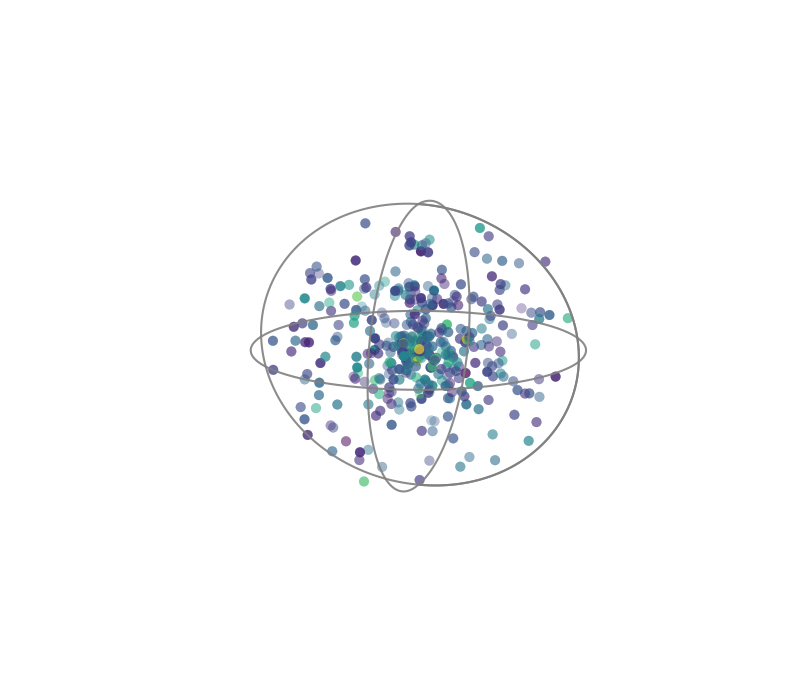

In [49]:
population.display_obs_fluxes_sphere(cmap='viridis',s=50);